In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# wrangling
import pandas as pd
import numpy as np

# preparing
from sklearn.model_selection import train_test_split

# visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# exploring
import scipy.stats as stats
import pandas_profiling

# modeling
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor

# 3D projection
from mpl_toolkits.mplot3d import Axes3D

pd.options.display.float_format = '{:20,.2f}'.format

# my modules
import acquire
import summarize
import prepare

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

### Acquire & Summarize


Acquired zillow data using acquire.py (sequel query in this file)

In [2]:
# df = acquire.get_zillow_data()
# df.head()

In [3]:
df = pd.read_csv("zillow_dataframe.csv")

In [4]:
df = df.drop(columns=["Unnamed: 0", "garagetotalsqft", "poolsizesum", "taxdelinquencyflag", "taxdelinquencyyear", "transactions"])

In [5]:
df.shape

(52169, 15)

In [6]:
# df = prepare.handle_missing_values(df)

In [7]:
df.isnull().sum()

tax_rate                            5
bathroomcnt                         0
bedroomcnt                          0
calculatedfinishedsquarefeet        8
fips                                0
garagecarcnt                    34203
latitude                            0
longitude                           0
lotsizesquarefeet                 354
poolcnt                         41105
taxvaluedollarcnt                   1
yearbuilt                          40
landtaxvaluedollarcnt               1
logerror                            0
county_name                         0
dtype: int64

In [8]:
df.latitude = df.latitude / 1_000_000 
df.longitude = df.longitude / 1_000_000 

### Clustering fips - aka binning the 3 different counties

In [9]:
from sklearn.cluster import KMeans

X = df[['fips']]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

X['cluster'] = pd.Series(kmeans.predict(X)).astype(str)

In [10]:
X.shape

(52169, 2)

In [11]:
X = X.drop(columns='fips')

In [12]:
df['cluster'] = X.cluster

In [13]:
def encode(df, col_name):
    
    encoded_values = sorted(list(df[col_name].unique()))

    # Integer Encoding
    int_encoder = LabelEncoder()
    df.encoded = int_encoder.fit_transform(df[col_name])

    # create 2D np arrays of the encoded variable (in train and test)
    df_array = np.array(df.encoded).reshape(len(df.encoded),1)

    # One Hot Encoding
    ohe = OneHotEncoder(sparse=False, categories='auto')
    df_ohe = ohe.fit_transform(df_array)

    # Turn the array of new values into a data frame with columns names being the values
    # and index matching that of train/test
    # then merge the new dataframe with the existing train/test dataframe
    df_encoded = pd.DataFrame(data=df_ohe, columns=encoded_values, index=df.index)
    df = df.join(df_encoded)

    return df, ohe

In [14]:
df, ohe = encode(df, 'cluster')

In [15]:
ohe.inverse_transform(df[['0', '1', '2']])

array([[2],
       [1],
       [2],
       ...,
       [0],
       [0],
       [0]])

In [16]:
df = df.drop(columns='cluster')

df['los_angeles'] = df['0']
df['ventura'] = df['1']
df['orange'] = df['2']

df = df.drop(columns=['0', '1', '2'])

### Split the data into train and test, 70/30

In [17]:
train, test = train_test_split(df, test_size=.30, random_state=123)

In [18]:
train.shape

(36518, 18)

In [19]:
test.shape

(15651, 18)

### Impute "poolcnt", "garagecarcnt" with 0s using a function.

 - Run this on train and test subsets separately

In [20]:
cols = ["poolcnt", "garagecarcnt"]

In [21]:
# Impute zeros into poolcnt and garagecarcnt on train set

train = prepare.fill_zero(train, cols=cols)

In [22]:
# Impute zeros into poolcnt and garagecarcnt on test set

test = prepare.fill_zero(test, cols=cols)

### Drop columns then rows using function

 - Run this on train and test subsets separately

In [23]:
# drop columns that have more than 50% of values missing and rows with more than 75% of values missing

train = prepare.handle_missing_values(train)

In [24]:
# drop columns that have more than 50% of values missing and rows with more than 75% of values missing

test = prepare.handle_missing_values(test)

### Drop the remaining Nulls in df to get clean train and test data sets

In [25]:
train.dropna(inplace=True)

In [26]:
test.dropna(inplace=True)

### THE train and test subsets with no missing values and poolcnt and garagecarcnt imputed with zeros. Outliers still in these subsets!

- I left county_name in these df for ease of exploration and viz. 

- Drop county_name and use fips for modeling and clustering purposes.

- If you want train and test with outliers handled, see below...

In [27]:
train.isnull().sum()

tax_rate                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
garagecarcnt                    0
latitude                        0
longitude                       0
lotsizesquarefeet               0
poolcnt                         0
taxvaluedollarcnt               0
yearbuilt                       0
landtaxvaluedollarcnt           0
logerror                        0
county_name                     0
los_angeles                     0
ventura                         0
orange                          0
dtype: int64

In [28]:
test.isnull().sum()

tax_rate                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
garagecarcnt                    0
latitude                        0
longitude                       0
lotsizesquarefeet               0
poolcnt                         0
taxvaluedollarcnt               0
yearbuilt                       0
landtaxvaluedollarcnt           0
logerror                        0
county_name                     0
los_angeles                     0
ventura                         0
orange                          0
dtype: int64

In [29]:
train.bedroomcnt.value_counts()

 3.00    16310
 4.00    10614
 2.00     5838
 5.00     2760
 6.00      451
 1.00      440
 7.00       75
 8.00       20
 9.00        6
10.00        2
14.00        1
12.00        1
Name: bedroomcnt, dtype: int64

In [30]:
train.bathroomcnt.value_counts()

 2.00    15260
 3.00     7474
 1.00     6627
 2.50     2804
 4.00     1571
 3.50      630
 1.50      578
 5.00      542
 4.50      482
 6.00      224
 5.50      160
 7.00       57
 8.00       40
 6.50       35
 7.50       14
 9.00       11
10.00        3
 8.50        2
11.00        2
18.00        1
13.00        1
Name: bathroomcnt, dtype: int64

Zillow's log error was low on the los angeles high priced outlier.  LA county houses seems to have the highest log error outliers

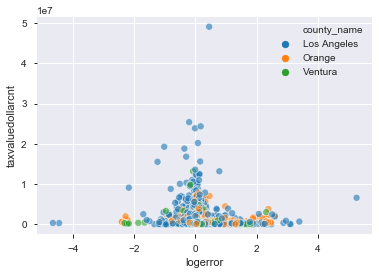

In [31]:
sns.scatterplot(data=train, x="logerror", y="taxvaluedollarcnt", hue="county_name", hue_order=["Los Angeles", "Orange", "Ventura"] , alpha=.6)

Before outliers

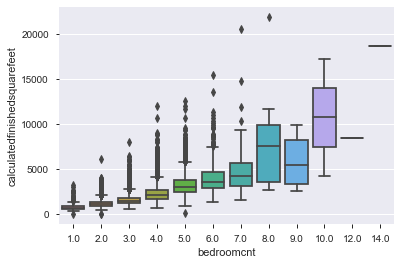

In [32]:
sns.boxplot(train.bedroomcnt, train.calculatedfinishedsquarefeet)

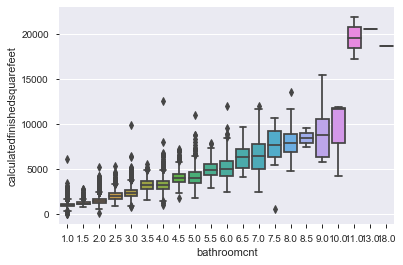

In [33]:
sns.boxplot(train.bathroomcnt, train.calculatedfinishedsquarefeet)

### Handle outliers by removing values < Q1 - IQR * 1.5 and values > Q3 + IQR * 1.5

In [34]:
train = prepare.remove_outliers_iqr(train, columns=["bedroomcnt", "bathroomcnt", "lotsizesquarefeet"], k=1.5)
train.shape

(30982, 18)

In [35]:
test = prepare.remove_outliers_iqr(test, columns=["bedroomcnt", "bathroomcnt", "lotsizesquarefeet"], k=1.5)
test.shape

(13273, 18)

### Convert dtypes to category for the cols below

- train_cat and test_cat are subsets with dtypes converted to category for the following columns:

    - "bathroomcnt", "bedroomcnt", "poolcnt", "yearbuilt", "garagecarcnt", "county_name"
    
- train_cat and test_cat also have outliers handled and no missing values.

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30982 entries, 22620 to 15725
Data columns (total 18 columns):
tax_rate                        30982 non-null float64
bathroomcnt                     30982 non-null float64
bedroomcnt                      30982 non-null float64
calculatedfinishedsquarefeet    30982 non-null float64
fips                            30982 non-null float64
garagecarcnt                    30982 non-null float64
latitude                        30982 non-null float64
longitude                       30982 non-null float64
lotsizesquarefeet               30982 non-null float64
poolcnt                         30982 non-null float64
taxvaluedollarcnt               30982 non-null float64
yearbuilt                       30982 non-null float64
landtaxvaluedollarcnt           30982 non-null float64
logerror                        30982 non-null float64
county_name                     30982 non-null object
los_angeles                     30982 non-null float64
ventura 

In [37]:
cols = ["bathroomcnt", "bedroomcnt", "poolcnt", "yearbuilt", "garagecarcnt", "county_name"]

In [38]:
train_cat = prepare.numeric_to_category(train, cols)

In [39]:
test_cat = prepare.numeric_to_category(test, cols)

In [40]:
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30982 entries, 22620 to 15725
Data columns (total 18 columns):
tax_rate                        30982 non-null float64
bathroomcnt                     30982 non-null category
bedroomcnt                      30982 non-null category
calculatedfinishedsquarefeet    30982 non-null float64
fips                            30982 non-null float64
garagecarcnt                    30982 non-null category
latitude                        30982 non-null float64
longitude                       30982 non-null float64
lotsizesquarefeet               30982 non-null float64
poolcnt                         30982 non-null category
taxvaluedollarcnt               30982 non-null float64
yearbuilt                       30982 non-null category
landtaxvaluedollarcnt           30982 non-null float64
logerror                        30982 non-null float64
county_name                     30982 non-null category
los_angeles                     30982 non-null float64
v

In [41]:
train.bedroomcnt.value_counts()

3.00    14880
4.00     8904
2.00     5424
5.00     1774
Name: bedroomcnt, dtype: int64

In [42]:
train.bathroomcnt.value_counts()

2.00    14117
1.00     6032
3.00     6012
2.50     2595
4.00      934
3.50      492
1.50      470
4.50      330
Name: bathroomcnt, dtype: int64

## Bin yearbuilt by Decade

- 1878 - 2015

- Drop 11 rows with yearbuilt == 0.00

In [43]:
train_cat["yearbuilt"] = train_cat["yearbuilt"].astype(int)

In [44]:
test_cat["yearbuilt"] = test_cat["yearbuilt"].astype(int)

In [45]:
# There are 11 rows with 0 value for yearbuilt. Drop these below.

train_cat.yearbuilt.value_counts().sort_index(ascending=True)

0        11
1878      1
1882      1
1885      3
1887      2
1888      2
1889      1
1890      5
1893      3
1895      9
1896      3
1898      2
1900      6
1901     11
1902      6
1903     12
1904     13
1905     38
1906     33
1907     29
1908     30
1909     48
1910     72
1911     62
1912     75
1913     55
1914     43
1915     48
1916     23
1917     27
       ... 
1986    338
1987    393
1988    272
1989    475
1990    346
1991    115
1992    186
1993    165
1994    219
1995    191
1996    190
1997    216
1998    196
1999    242
2000    272
2001    279
2002    213
2003    250
2004    219
2005    247
2006    212
2007    158
2008     58
2009     45
2010     53
2011     34
2012     56
2013     69
2014     70
2015     23
Name: yearbuilt, Length: 128, dtype: int64

In [46]:
train_cat = train_cat[train_cat["yearbuilt"] != 0.00]

In [47]:
test_cat = test_cat[test_cat["yearbuilt"] != 0.00]

In [48]:
# bin train df yearbuilt by decade, 1800 dates are all in one bin.

bins = [1878, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]

train_cat["decade"] = pd.cut(x=train_cat['yearbuilt'], bins=bins)

In [49]:
# convert decade column to category dtype

train_cat["decade"] = train_cat.decade.astype('category')

In [50]:
# bin test df yearbuilt by decade, 1800 dates are all in one bin.


test_cat["decade"] = pd.cut(x=test_cat['yearbuilt'], bins=bins)

In [51]:
# convert decade column to category dtype

test_cat["decade"] = test_cat.decade.astype('category')

In [52]:
train_cat.groupby("decade").count()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,los_angeles,ventura,orange
decade,,,,,,,,,,,,,,,,,,
"(1878, 1900]",37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37
"(1900, 1910]",292,292,292,292,292,292,292,292,292,292,292,292,292,292,292,292,292,292
"(1910, 1920]",516,516,516,516,516,516,516,516,516,516,516,516,516,516,516,516,516,516
"(1920, 1930]",2168,2168,2168,2168,2168,2168,2168,2168,2168,2168,2168,2168,2168,2168,2168,2168,2168,2168
"(1930, 1940]",1415,1415,1415,1415,1415,1415,1415,1415,1415,1415,1415,1415,1415,1415,1415,1415,1415,1415
"(1940, 1950]",4098,4098,4098,4098,4098,4098,4098,4098,4098,4098,4098,4098,4098,4098,4098,4098,4098,4098
"(1950, 1960]",7670,7670,7670,7670,7670,7670,7670,7670,7670,7670,7670,7670,7670,7670,7670,7670,7670,7670
"(1960, 1970]",4596,4596,4596,4596,4596,4596,4596,4596,4596,4596,4596,4596,4596,4596,4596,4596,4596,4596
"(1970, 1980]",3454,3454,3454,3454,3454,3454,3454,3454,3454,3454,3454,3454,3454,3454,3454,3454,3454,3454


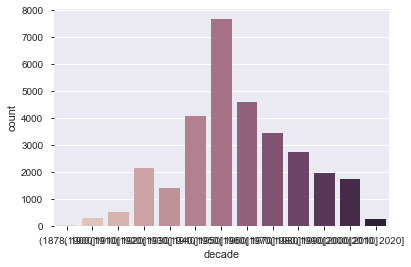

In [53]:
sns.countplot(x='decade', palette="ch:.10", data=train_cat, )

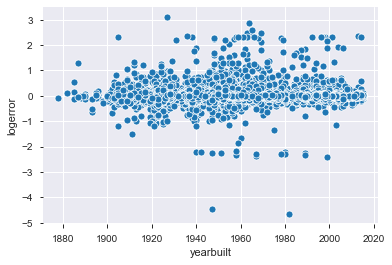

In [54]:

sns.scatterplot(data=train_cat, x="yearbuilt", y="logerror")

### Feature Engineer poolcnt and garagecarcnt into one column

In [55]:
train["poolcnt"] = train["poolcnt"].astype(int)

In [56]:
test["poolcnt"] = test["poolcnt"].astype(int)

In [57]:
train["poolcnt"].value_counts().sort_index(ascending=True)

0    25691
1     5291
Name: poolcnt, dtype: int64

In [58]:
test["poolcnt"].value_counts().sort_index(ascending=True)

0    11016
1     2257
Name: poolcnt, dtype: int64

In [59]:
train["garagecarcnt"] = train["garagecarcnt"].astype(int)

In [60]:
test["garagecarcnt"] = test["garagecarcnt"].astype(int)

In [61]:
train["garagecarcnt"].value_counts().sort_index(ascending=True)

0     19943
1      1384
2      9412
3       199
4        39
5         2
6         2
10        1
Name: garagecarcnt, dtype: int64

In [62]:
# defines conditions to compute the correct value for extras in train

conditions = [
    (train["poolcnt"] == 0) & (train["garagecarcnt"] == 0),
    (train["poolcnt"] > 0) & (train["garagecarcnt"] == 0),
    (train["poolcnt"] == 0) & (train["garagecarcnt"] > 0),
    (train["poolcnt"] > 0) & (train["garagecarcnt"] > 0)
]

In [63]:
# defines value to put in extras column based on conditions above

outputs = [0, 1, 1, 2]

In [64]:
# Create new columns that has a 0 if a home has neither pool nor garage
#                               1 if a home has either pool or garage
#                               2 if a home has both pool and garage

train["extras"] = np.select(conditions, outputs, 'Other')

In [65]:
train.head(1)

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,los_angeles,ventura,orange,extras
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2,33.85,-118.02,"6,000.00",0,"143,427.00",1955,"88,553.00",-0.08,Orange,0.00,0.00,1.00,1


In [66]:
test.head(1)

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,los_angeles,ventura,orange
10408,0.03,2.00,3.00,"1,064.00","6,037.00",0,34.58,-118.06,"7,046.00",0,"65,261.00",1956,"27,191.00",-0.02,Los Angeles,1.00,0.00,0.00


In [67]:
# defines conditions to compute the correct value for extras in train

conditions = [
    (test["poolcnt"] == 0) & (test["garagecarcnt"] == 0),
    (test["poolcnt"] > 0) & (test["garagecarcnt"] == 0),
    (test["poolcnt"] == 0) & (test["garagecarcnt"] > 0),
    (test["poolcnt"] > 0) & (test["garagecarcnt"] > 0)
]

In [68]:
test["extras"] = np.select(conditions, outputs, 'Other')

In [69]:
test.head(1)

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,los_angeles,ventura,orange,extras
10408,0.03,2.00,3.00,"1,064.00","6,037.00",0,34.58,-118.06,"7,046.00",0,"65,261.00",1956,"27,191.00",-0.02,Los Angeles,1.00,0.00,0.00,0


## Visualize

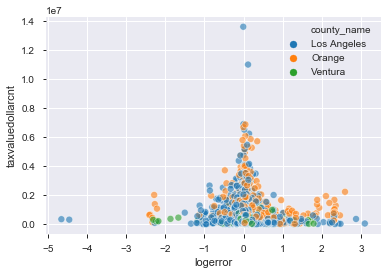

In [70]:
sns.scatterplot(data=train, x="logerror", y="taxvaluedollarcnt", hue="county_name", hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

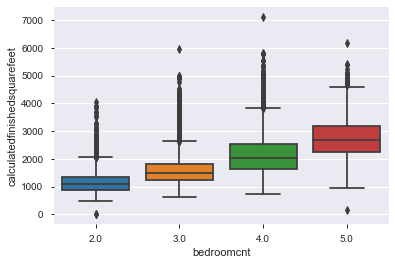

In [71]:
sns.boxplot(train.bedroomcnt, train.calculatedfinishedsquarefeet)

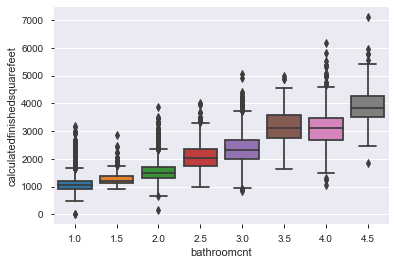

In [72]:
sns.boxplot(train.bathroomcnt, train.calculatedfinishedsquarefeet)

## Stats Testing to Decide on Feature Engineering

- Here I use a chi2 test to look at categorical features.

- $H_0$: Bathroomcnt is independent of how many bedrooms a home has.

- $H_a$: Bathroomcnt is not independent of how many bedrooms a home has.

In [73]:
# contingency_table from the df_cat dataframe (w/o categories)

contingency_table = pd.crosstab(train_cat.bedroomcnt, train_cat.bathroomcnt).style.background_gradient(cmap='YlOrRd')
contingency_table

bathroomcnt,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5
bedroomcnt,,,,,,,,
2.0,3409,103,1619,127,149,8,5,0
3.0,2450,295,8705,1274,1838,124,172,20
4.0,149,71,3575,1080,3140,277,446,161
5.0,19,1,216,114,883,82,311,148


In [74]:
contingency_table = pd.crosstab(train_cat.bedroomcnt, train_cat.bathroomcnt)

In [75]:
_, p, _, expected = stats.chi2_contingency(contingency_table)

In [76]:
print(f"The p-value of the contingency test is {p}.")

The p-value of the contingency test is 0.0.


### Takeaways from chi2 test on bedroomcnt and bathroomcnt

- Based on the p_value of 0 from the chi2 test above, I reject the Null Hypothesis that bathroomcnt is independent of how many bedrooms a home has.


- Based on rejecting the Null Hypothesis, I will combine the two features into a single feature that is a ratio of bedrooms to bathrooms.

- $H_0$: garagecarcnt is independent of how many pools a home has.

- $H_a$: garagecarcnt is not independent of how many pools a home has.

In [77]:
contingency_table = pd.crosstab(train_cat.garagecarcnt, train_cat.poolcnt, margins=True).style.background_gradient(cmap='YlOrRd')
contingency_table

poolcnt,0.0,1.0,All
garagecarcnt,,,
0.0,16828,3109,19937
1.0,1243,140,1383
2.0,7461,1947,9408
3.0,121,78,199
4.0,22,17,39
5.0,2,0,2
6.0,2,0,2
10.0,1,0,1
All,25680,5291,30971


In [78]:
contingency_table = pd.crosstab(train_cat.garagecarcnt, train_cat.poolcnt)

In [79]:
_, p, _, expected = stats.chi2_contingency(contingency_table)

In [80]:
print(f"The p-value of the contingency test is {p}.")

The p-value of the contingency test is 3.4951449348417376e-51.


## Pearson r test on lot size and tax value

In [81]:
r, p = stats.pearsonr(train_cat.lotsizesquarefeet, train_cat.taxvaluedollarcnt)

In [82]:
print(f"r is {r}")

r is 0.0690533331345955


In [83]:
print(f"p is {p}")

p is 4.691049548815385e-34


## T-test of decade and taxvaluedollarcnt

- Can I do this? How do I use my decade intervals?

In [84]:
train_cat.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,los_angeles,ventura,orange,decade
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2.00,33.85,-118.02,"6,000.00",0.00,"143,427.00",1955,"88,553.00",-0.08,Orange,0.00,0.00,1.00,"(1950, 1960]"
35532,0.02,2.00,3.00,"1,812.00","6,037.00",0.00,34.05,-118.08,"10,906.00",0.00,"87,511.00",1957,"16,333.00",-0.04,Los Angeles,1.00,0.00,0.00,"(1950, 1960]"
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2.00,33.49,-117.64,"9,000.00",1.00,"1,005,040.00",1998,"576,786.00",0.03,Orange,0.00,0.00,1.00,"(1990, 2000]"
49147,0.01,3.00,4.00,"2,859.00","6,037.00",0.00,34.45,-118.57,"6,252.00",0.00,"644,000.00",2003,"330,000.00",0.07,Los Angeles,1.00,0.00,0.00,"(2000, 2010]"
43935,0.01,3.00,4.00,"2,512.00","6,037.00",0.00,34.16,-118.41,"7,042.00",1.00,"806,181.00",1974,"437,002.00",0.08,Los Angeles,1.00,0.00,0.00,"(1970, 1980]"


## Visualize Correlation between lot size and home value

In [85]:
train_cat.lotsizesquarefeet.value_counts().sort_index()

 1,048.00    1
 1,050.00    1
 1,053.00    1
 1,075.00    1
 1,078.00    1
 1,092.00    1
 1,116.00    1
 1,120.00    1
 1,130.00    1
 1,140.00    1
 1,141.00    1
 1,144.00    1
 1,152.00    1
 1,154.00    5
 1,155.00    2
 1,161.00    1
 1,176.00    1
 1,188.00    2
 1,196.00    1
 1,199.00    1
 1,200.00    2
 1,210.00    3
 1,228.00    1
 1,231.00    1
 1,235.00    1
 1,248.00    1
 1,256.00    1
 1,274.00    1
 1,276.00    1
 1,279.00    1
            ..
12,895.00    2
12,896.00    1
12,900.00    1
12,901.00    1
12,902.00    1
12,903.00    1
12,908.00    1
12,909.00    1
12,914.00    1
12,919.00    3
12,925.00    2
12,926.00    1
12,932.00    2
12,934.00    1
12,937.00    1
12,938.00    2
12,942.00    1
12,946.00    1
12,947.00    1
12,950.00    1
12,951.00    1
12,953.00    1
12,955.00    2
12,968.00    1
12,969.00    2
12,972.00    1
12,974.00    1
12,976.00    1
12,978.00    1
12,981.00    1
Name: lotsizesquarefeet, Length: 8184, dtype: int64

In [86]:
# creating df handling values above 10_000 sqfeet to get a better look at the relationship between the variables

#lot_no_outliers = train_cat[train_cat.lotsizesquarefeet > 10000]

In [87]:
lot_no_outliers = train_cat[train_cat.taxvaluedollarcnt < 2_000_000]

### DB Scan this thingy

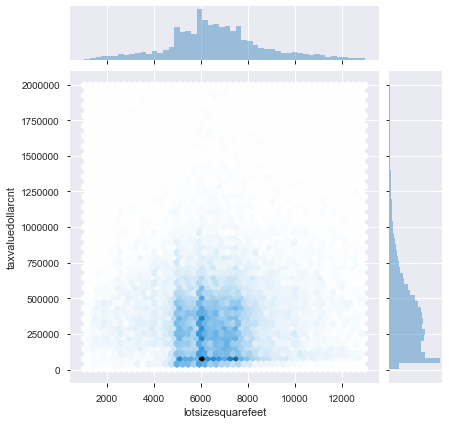

In [88]:
sns.jointplot(data=lot_no_outliers, y="taxvaluedollarcnt", x="lotsizesquarefeet", kind="hex")

## Split train and test into X_train, X_test, y_train, y_test

In [89]:
train = train.drop(columns='county_name')
test = test.drop(columns='county_name')

In [90]:
X_train = train.drop(columns="logerror")

y_train = train[["logerror"]]

X_test = test.drop(columns="logerror")

y_test = test[["logerror"]]

### Model df - Random Forest

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [92]:
rf = RandomForestRegressor(n_estimators=100)

In [93]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [94]:
from sklearn.metrics import mean_squared_error

y_pred = rf.predict(X_train)
print(f'root mean squared error = {mean_squared_error(y_train, y_pred)**1/2}')

root mean squared error = 0.0020191271974559256


In [95]:
y_pred = rf.predict(X_test)
print(f'root mean squared error = {mean_squared_error(y_test, y_pred)**1/2}')

root mean squared error = 0.014369760586992667


### PUT TAKEAWAYS FROM RANDOM FOREST MODEL HERE

## Model - Linear Regression Model

In [96]:
X_train.dtypes

tax_rate                         float64
bathroomcnt                     category
bedroomcnt                      category
calculatedfinishedsquarefeet     float64
fips                             float64
garagecarcnt                       int64
latitude                         float64
longitude                        float64
lotsizesquarefeet                float64
poolcnt                            int64
taxvaluedollarcnt                float64
yearbuilt                          int64
landtaxvaluedollarcnt            float64
los_angeles                      float64
ventura                          float64
orange                           float64
extras                            object
dtype: object

In [97]:
X_train.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,los_angeles,ventura,orange,extras
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2,33.85,-118.02,"6,000.00",0,"143,427.00",1955,"88,553.00",0.00,0.00,1.00,1
35532,0.02,2.00,3.00,"1,812.00","6,037.00",0,34.05,-118.08,"10,906.00",0,"87,511.00",1957,"16,333.00",1.00,0.00,0.00,0
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2,33.49,-117.64,"9,000.00",1,"1,005,040.00",1998,"576,786.00",0.00,0.00,1.00,2
49147,0.01,3.00,4.00,"2,859.00","6,037.00",0,34.45,-118.57,"6,252.00",0,"644,000.00",2003,"330,000.00",1.00,0.00,0.00,0
43935,0.01,3.00,4.00,"2,512.00","6,037.00",0,34.16,-118.41,"7,042.00",1,"806,181.00",1974,"437,002.00",1.00,0.00,0.00,1


In [98]:
X_train.garagecarcnt = X_train.garagecarcnt.astype(float)
X_train.bathroomcnt = X_train.bathroomcnt.astype(float)
X_train.bedroomcnt = X_train.bedroomcnt.astype(float)
X_train.poolcnt = X_train.poolcnt.astype(float)

In [99]:
X_train = X_train.drop(columns='yearbuilt')
X_test = X_test.drop(columns='yearbuilt')

In [100]:
# create the LR object

lm1 = LinearRegression()
print(lm1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [101]:
# fit/train the model

model = lm1.fit(X_train, y_train)

In [102]:
# create yhat variable, numpy array, in-sample prediction values

yhat = model.predict(X_train)
type(yhat)
yhat

array([[0.02222162],
       [0.02460522],
       [0.02210001],
       ...,
       [0.01279036],
       [0.01763535],
       [0.02739717]])

In [103]:
actual = y_train
actual.head()

,logerror
22620,-0.08
35532,-0.04
17905,0.03
49147,0.07
43935,0.08


In [104]:
actual['yhat'] = yhat

### Evaluate LR Model

In [105]:
actual["residual"] = actual["yhat"] - actual["logerror"]

In [106]:
actual.head(1)

,logerror,yhat,residual
22620,-0.08,0.02,0.10


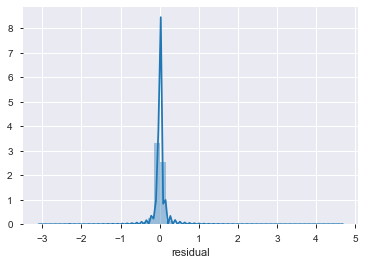

In [107]:
sns.distplot(actual["residual"])

In [108]:
#sns.jointplot(actual["logerror"], actual["yhat"], kind="resid")


In [109]:
actual["residual^2"] = actual["residual"] ** 2

In [110]:
sse = sum(actual["residual^2"])
print(f"sse = {sse}")
mse = sse / len(actual)
print(f"mse = {mse}")
rmse = sqrt(mse)
print(f"rmse = {rmse}")

sse = 845.9601905399343
mse = 0.02730489285843181
rmse = 0.16524192221840017


In [111]:
df_eval = pd.DataFrame(np.array(["SSE", "MSE", "RMSE"]), columns=["metric"])
df_eval["model_error"] = np.array([sse, mse, rmse])
df_eval

,metric,model_error
0,SSE,845.96
1,MSE,0.03
2,RMSE,0.17


- Create a numpy array from the y_df_nums_train df, so I can run eval metrics using yhat(prediction array) and y_array (array of actual y values)

In [112]:
y_array = np.array(y_train)
type(y_array)

numpy.ndarray

In [113]:
r2_score(actual.logerror, actual.yhat)

0.00401728297750481

In [114]:
mse_lm1 = mean_squared_error(actual.logerror, actual.yhat)
print("linear model\n  mean squared error: {:.3}".format(mse_lm1)) 

r2_lm1 = r2_score(actual.logerror, actual.yhat)
print('  {:.2%} of the variance in the logerror can be explained by variables.'.format(r2_lm1))

linear model
  mean squared error: 0.0273
  0.40% of the variance in the logerror can be explained by variables.


### Takeaways from the Linear Regression Model:

- Based on the results above I fail to reject the Null Hypothesis that the numeric values alone can predict the logerror.

- Using a Linear Regression model to predict the logerror may not be the best choice.

- Finding a way to include categorical variables in a model may help predict logerror.

### Model - K Neighbors Regressor

In [115]:
# create the object
neigh = KNeighborsRegressor(n_neighbors=2)

In [116]:
# fit/train the model using train 
neigh.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [117]:
yhat = neigh.predict(X_train)
type(yhat)

numpy.ndarray

In [118]:
r2 = neigh.score(X_train, y_train)

In [119]:
print('  {:.2%} of the variance in the logerror can be explained by variables.'.format(r2))

  44.05% of the variance in the logerror can be explained by variables.


### Takeaways from KNRegressor Model

- This model explained more than 40% more of the variance in logerror than my LR model using exactly the same data.

- The subset of data I used was comprised of the numeric values only from the original dataframe.

- I think this model could do even better with outliers handled and some feature engineering.